# Exploring the Hugging Face Dataset and Model APIs

This example demonstrates loading a subset of a dataset located on Hugging Face's hub and then using that data within an object detection "pipeline" to get predictions from a model hosted on Hugging Face's hub.

## Environment Setup

Here we install `datasets` and `transformers` from Hugging Face, as well as matplotlib for some quick visualization.

The model we will be using for this example utilizes PyTorch Image Models (`timm`) so we will also install that now. Note Python 3.7+ is required for PyTorch.

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing timm...")
!{sys.executable} -m pip install -q timm
print("Done!")

Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing matplotlib...
Installing timm...
Done!


## Inspect and Load Dataset

Before loading the dataset, we can inspect it using `load_dataset_builder`. We'll be using a dataset of images from chapbooks held by the National Library of Scotland, the dataset card can be found [here](https://huggingface.co/datasets/biglam/nls_chapbook_illustrations "biglam/nls_chapbook_illustrations Dataset Card").

The first argument to the load dataset builder specifies the dataset we're interested in while the second specifies a subset of that particular dataset.

In [2]:
from datasets import load_dataset_builder

ds_builder = load_dataset_builder("biglam/nls_chapbook_illustrations", "illustration-detection")

In [3]:
# Inspect dataset description
ds_builder.info.description

'This dataset comprises of images from chapbooks held by the National Library of Scotland and digitised and published as its Chapbooks Printed in Scotland dataset'

In [4]:
# Inspect dataset features
ds_builder.info.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': [{'category_id': ClassLabel(names=['early_printed_illustration'], id=None),
   'image_id': Value(dtype='string', id=None),
   'id': Value(dtype='int64', id=None),
   'area': Value(dtype='int64', id=None),
   'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None),
   'segmentation': [[Value(dtype='float32', id=None)]],
   'iscrowd': Value(dtype='bool', id=None)}]}

We can then actually load the dataset, with the same arguments as before. Hugging Face will cache downloaded information to avoid unnecessarily downloading duplicate data.

In [5]:
from datasets import load_dataset

ds = load_dataset("biglam/nls_chapbook_illustrations", "illustration-detection")

Found cached dataset nls_chapbook_illustrations (/home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Inspect dataset structure
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 7258
    })
})

We can see from inspecting the dataset (or looking at the dataset card) that this dataset only has a single split, `train`.

In [7]:
ds_train = ds["train"]

In [8]:
# Inspect example datum structure
ds_train[0]

{'image_id': 4,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x1080>,
 'width': 600,
 'height': 1080,
 'objects': [{'category_id': 0,
   'image_id': '4',
   'id': 1,
   'area': 110901,
   'bbox': [34.529998779296875,
    556.8300170898438,
    401.44000244140625,
    276.260009765625],
   'segmentation': [[34.529998779296875,
     556.8300170898438,
     435.9700012207031,
     556.8300170898438,
     435.9700012207031,
     833.0900268554688,
     34.529998779296875,
     833.0900268554688]],
   'iscrowd': False}]}

In [9]:
# For this example, shuffle the dataset to look at random sampling of the data.
ds_train_shuffle = ds_train.shuffle(seed=0)

num_predictions = 4

Loading cached shuffled indices for dataset at /home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4/cache-47a1184601205ace.arrow


# Using Hugging Face's Pipeline for Model Predictions

Hugging Face gives users a "pipeline" for rapid prediction making using pre-trained models.

## Pipeline Setup

`Auto` classes serve as generic classes that will be instantiated as one of the derived classes of the library. `Tokenizers` or, in the case of vision-based models, `FeatureExtractors` are used to get the data in the format the model expects. We're using `AutoModelForObjectDetection` which is specifically for models with an object detection head.

For this example, we will be using `davanstrien/detr-resnet-50_fine_tuned_nls_chapbooks` which is a version of the `facebook/detr-resnet50` model fine-tuned for the dataset we've loaded. The model card for this model can be found [here](https://huggingface.co/biglam/detr-resnet-50_fine_tuned_nls_chapbooks "biglam/detr-resnet-50_fine_tuned_nls_chapbooks Model Card").

In [10]:
from transformers import pipeline, AutoFeatureExtractor, AutoModelForObjectDetection

extractor = AutoFeatureExtractor.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
model = AutoModelForObjectDetection.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")

Once we have our model and feature extractor, we can set up our pipeline.

In [11]:
obj_detection_pipe = pipeline("object-detection", model=model, feature_extractor=extractor)

## Data Predictions

Then we simply have to provide our data to the pipeline to get predictions.

In [12]:
results = obj_detection_pipe(ds_train_shuffle[0:num_predictions]['image'])

# Inspect results
results

/home/local/KHQ/emily.veenhuis/Documents/xaitk-cdao/examples/huggingface/env/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:848: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


[[{'score': 0.9966813921928406,
   'label': 'early_printed_illustration',
   'box': {'xmin': 40, 'ymin': 571, 'xmax': 359, 'ymax': 824}}],
 [],
 [{'score': 0.9962982535362244,
   'label': 'early_printed_illustration',
   'box': {'xmin': 71, 'ymin': 18, 'xmax': 439, 'ymax': 368}}],
 [{'score': 0.9955165982246399,
   'label': 'early_printed_illustration',
   'box': {'xmin': 30, 'ymin': 562, 'xmax': 482, 'ymax': 931}}]]

## Prediction Visualization

In [13]:
import matplotlib.pyplot as plt

COLORS = ['c', 'm', 'y', 'b', 'g', 'r', 'w']

def plot_results(image, results, fig_num):
    plt.figure(fig_num)
    plt.imshow(image)
    ax = plt.gca()
    for idx, result in enumerate(results):
        box = result['box']
        xmin, xmax, ymin, ymax = box['xmin'], box['xmax'], box['ymin'], box['ymax']
        label = result['label']
        prob = result['score']
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=COLORS[idx%len(COLORS)], linewidth=3))
        text = f'{label}: {prob:0.2f}'
        ax.text(xmin, ymin, text, fontsize=12, bbox=dict(facecolor=COLORS[idx%len(COLORS)], alpha=0.5))
    plt.axis('off')
    plt.show()

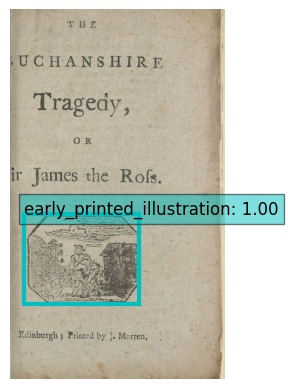

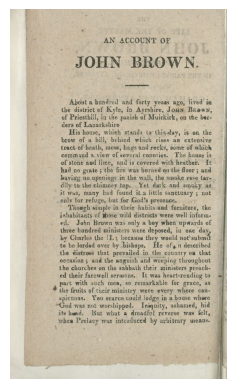

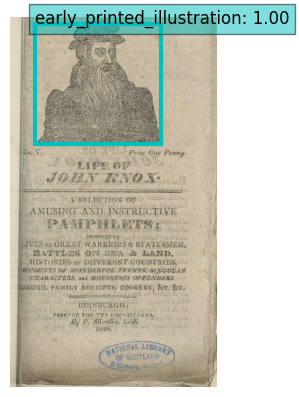

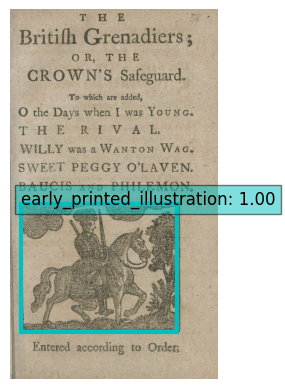

In [14]:
for i in range(0,num_predictions):
    plot_results(ds_train_shuffle[i]['image'], results[i], i)